### Simpsons Episode Ratings

This notebook extracts episode ratings for the simpsons from IMDB, then visualises them in the style of a graphic made by <a href="https://public.tableau.com/profile/hannes.benne#!/vizhome/SimpsonsEpisodeRating/EpisodeRating">Hannes Benne</a>

<br>

### Imports

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.transforms import Bbox
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

from bs4 import BeautifulSoup as bs
import requests

from ipypb import track

<br>

### Helper Functions

In [2]:
def hide_spines(ax, positions=['top', 'right']):
    """
    Pass a matplotlib axis and list of positions with spines to be removed
    
    args:
        ax:          Matplotlib axis object
        positions:   Python list e.g. ['top', 'bottom']
    """
    assert isinstance(positions, list), 'Position must be passed as a list '
    
    for position in positions:
        ax.spines[position].set_visible(False)

<br>

### Data Retrieval

We start by identifying the number of seasons that the show contains

In [3]:
show_id_2_url = lambda show_id: f'https://www.imdb.com/title/{show_id}'

show_id = 'tt0096697'
show_url = show_id_2_url(show_id)

show_url

'https://www.imdb.com/title/tt0096697'

<br>

We'll do this by looking at the first season IMDB lists (which is always the most recent)

In [4]:
def show_id_2_most_recent_season(show_id):
    show_url = show_id_2_url(show_id)
    r = requests.get(show_url)
    assert r.status_code==200, f'Request failed with code: {r.status_code}'

    soup = bs(r.content)
    season_year_links = soup.find('div', attrs={'class':'seasons-and-year-nav'}).find_all('a')
    most_recent_season = int([tag.text for tag in season_year_links][0])

    return most_recent_season

most_recent_season = show_id_2_most_recent_season(show_id)

most_recent_season

32

<br>

Next we'll create a helper function to create the url for each season's data

In [5]:
season_2_url = lambda show_id, season: f'https://www.imdb.com/title/{show_id}/episodes/_ajax?season={season}'

season_url = season_2_url(show_id, 1)

season_url

'https://www.imdb.com/title/tt0096697/episodes/_ajax?season=1'

<br>

We'll then use this to extract the episode ratings from a season

In [6]:
def season_2_episode_ratings(show_id, season):
    season_url = season_2_url(show_id, season)
    r = requests.get(season_url)
    assert r.status_code==200, f'Request failed with code: {r.status_code}'

    soup = bs(r.content)
    episode_ratings = (soup
                       .find('div', attrs={'class', 'list detail eplist'})
                       .find_all('div', {'class':'ipl-rating-widget'}))
    ratings = [float(rating.find('span', attrs={'class':'ipl-rating-star__rating'}).text) 
               for rating in episode_ratings]

    return ratings

ratings = season_2_episode_ratings(show_id, 1)

ratings

[8.2, 7.7, 7.4, 7.7, 8.0, 7.6, 7.8, 7.7, 7.5, 7.4, 7.8, 8.4, 7.8]

<br>

And repeat this until we get to the final season

In [7]:
def show_id_2_ratings_df(show_id):
    df_ratings = pd.DataFrame(index=range(100))
    most_recent_season = show_id_2_most_recent_season(show_id)

    for season in track(range(1, most_recent_season+1)):
        ratings = season_2_episode_ratings(show_id, season)
        df_ratings[season] = pd.Series(ratings, dtype='float64')

    df_ratings = (df_ratings
                  .dropna(how='all', axis=0)
                  .dropna(how='all', axis=1)
                 ) 
    
    df_ratings.index += 1

    return df_ratings

df_ratings = show_id_2_ratings_df(show_id)
    
df_ratings.head()

 [████████████████████████████████████████████████████████████] 32/32 [00:32<00:00, 1.01s/it]

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
1,8.2,8.2,8.6,8.5,8.5,8.7,9.0,8.4,9.1,7.6,...,6.1,7.0,6.3,6.8,5.6,5.6,6.0,6.7,6.2,5.7
2,7.7,8.2,7.8,8.2,9.2,8.1,8.3,9.2,7.0,8.2,...,6.7,7.0,7.2,6.9,6.8,6.6,6.5,6.5,6.0,5.8
3,7.4,8.3,8.2,9.0,8.6,5.9,8.4,8.1,8.1,7.6,...,6.6,6.4,6.8,6.3,6.4,7.0,7.0,6.1,6.1,6.5
4,7.7,8.1,8.6,7.8,8.9,8.6,8.8,7.7,8.2,8.0,...,7.0,6.4,6.6,6.4,7.4,7.5,6.9,7.1,5.9,6.9
5,8.0,7.5,8.5,8.5,8.8,8.3,8.5,8.3,8.2,7.3,...,7.1,7.0,6.2,6.8,6.1,6.6,6.3,6.3,7.0,6.1


<br>

We'll quickly save it

In [20]:
df_ratings.index.name = 'episode'

df_ratings.to_csv('data/simpsons_ratings.csv')

<br>

### Plotting

Before we get too far into the plot design we'll specify the colour palette

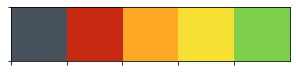

In [10]:
def colors_n_segments_2_pairs(colors, color_segment_starts):
    color_loc_pairs = []

    for idx, color in enumerate(colors):
        if idx == 0:
            color_loc_pairs += [(color_segment_starts[idx], color)]
        else:
            color_loc_pairs += [(color_segment_starts[idx], colors[idx-1])]
            color_loc_pairs += [(color_segment_starts[idx], color)]

    color_loc_pairs += [(1, colors[-1])]

    return color_loc_pairs

colors = ['#48525D', '#C82912', '#FEA926', '#F5E033', '#7DCF4C']
color_segment_starts = [0, 0.5, 0.65, 0.75, 0.85]

color_loc_pairs = colors_n_segments_2_pairs(colors, color_segment_starts)
simpsons_cm = LinearSegmentedColormap.from_list('simpsons', color_loc_pairs)

sns.palplot(sns.color_palette(colors))

<br>

Now we'll create the axes with the data

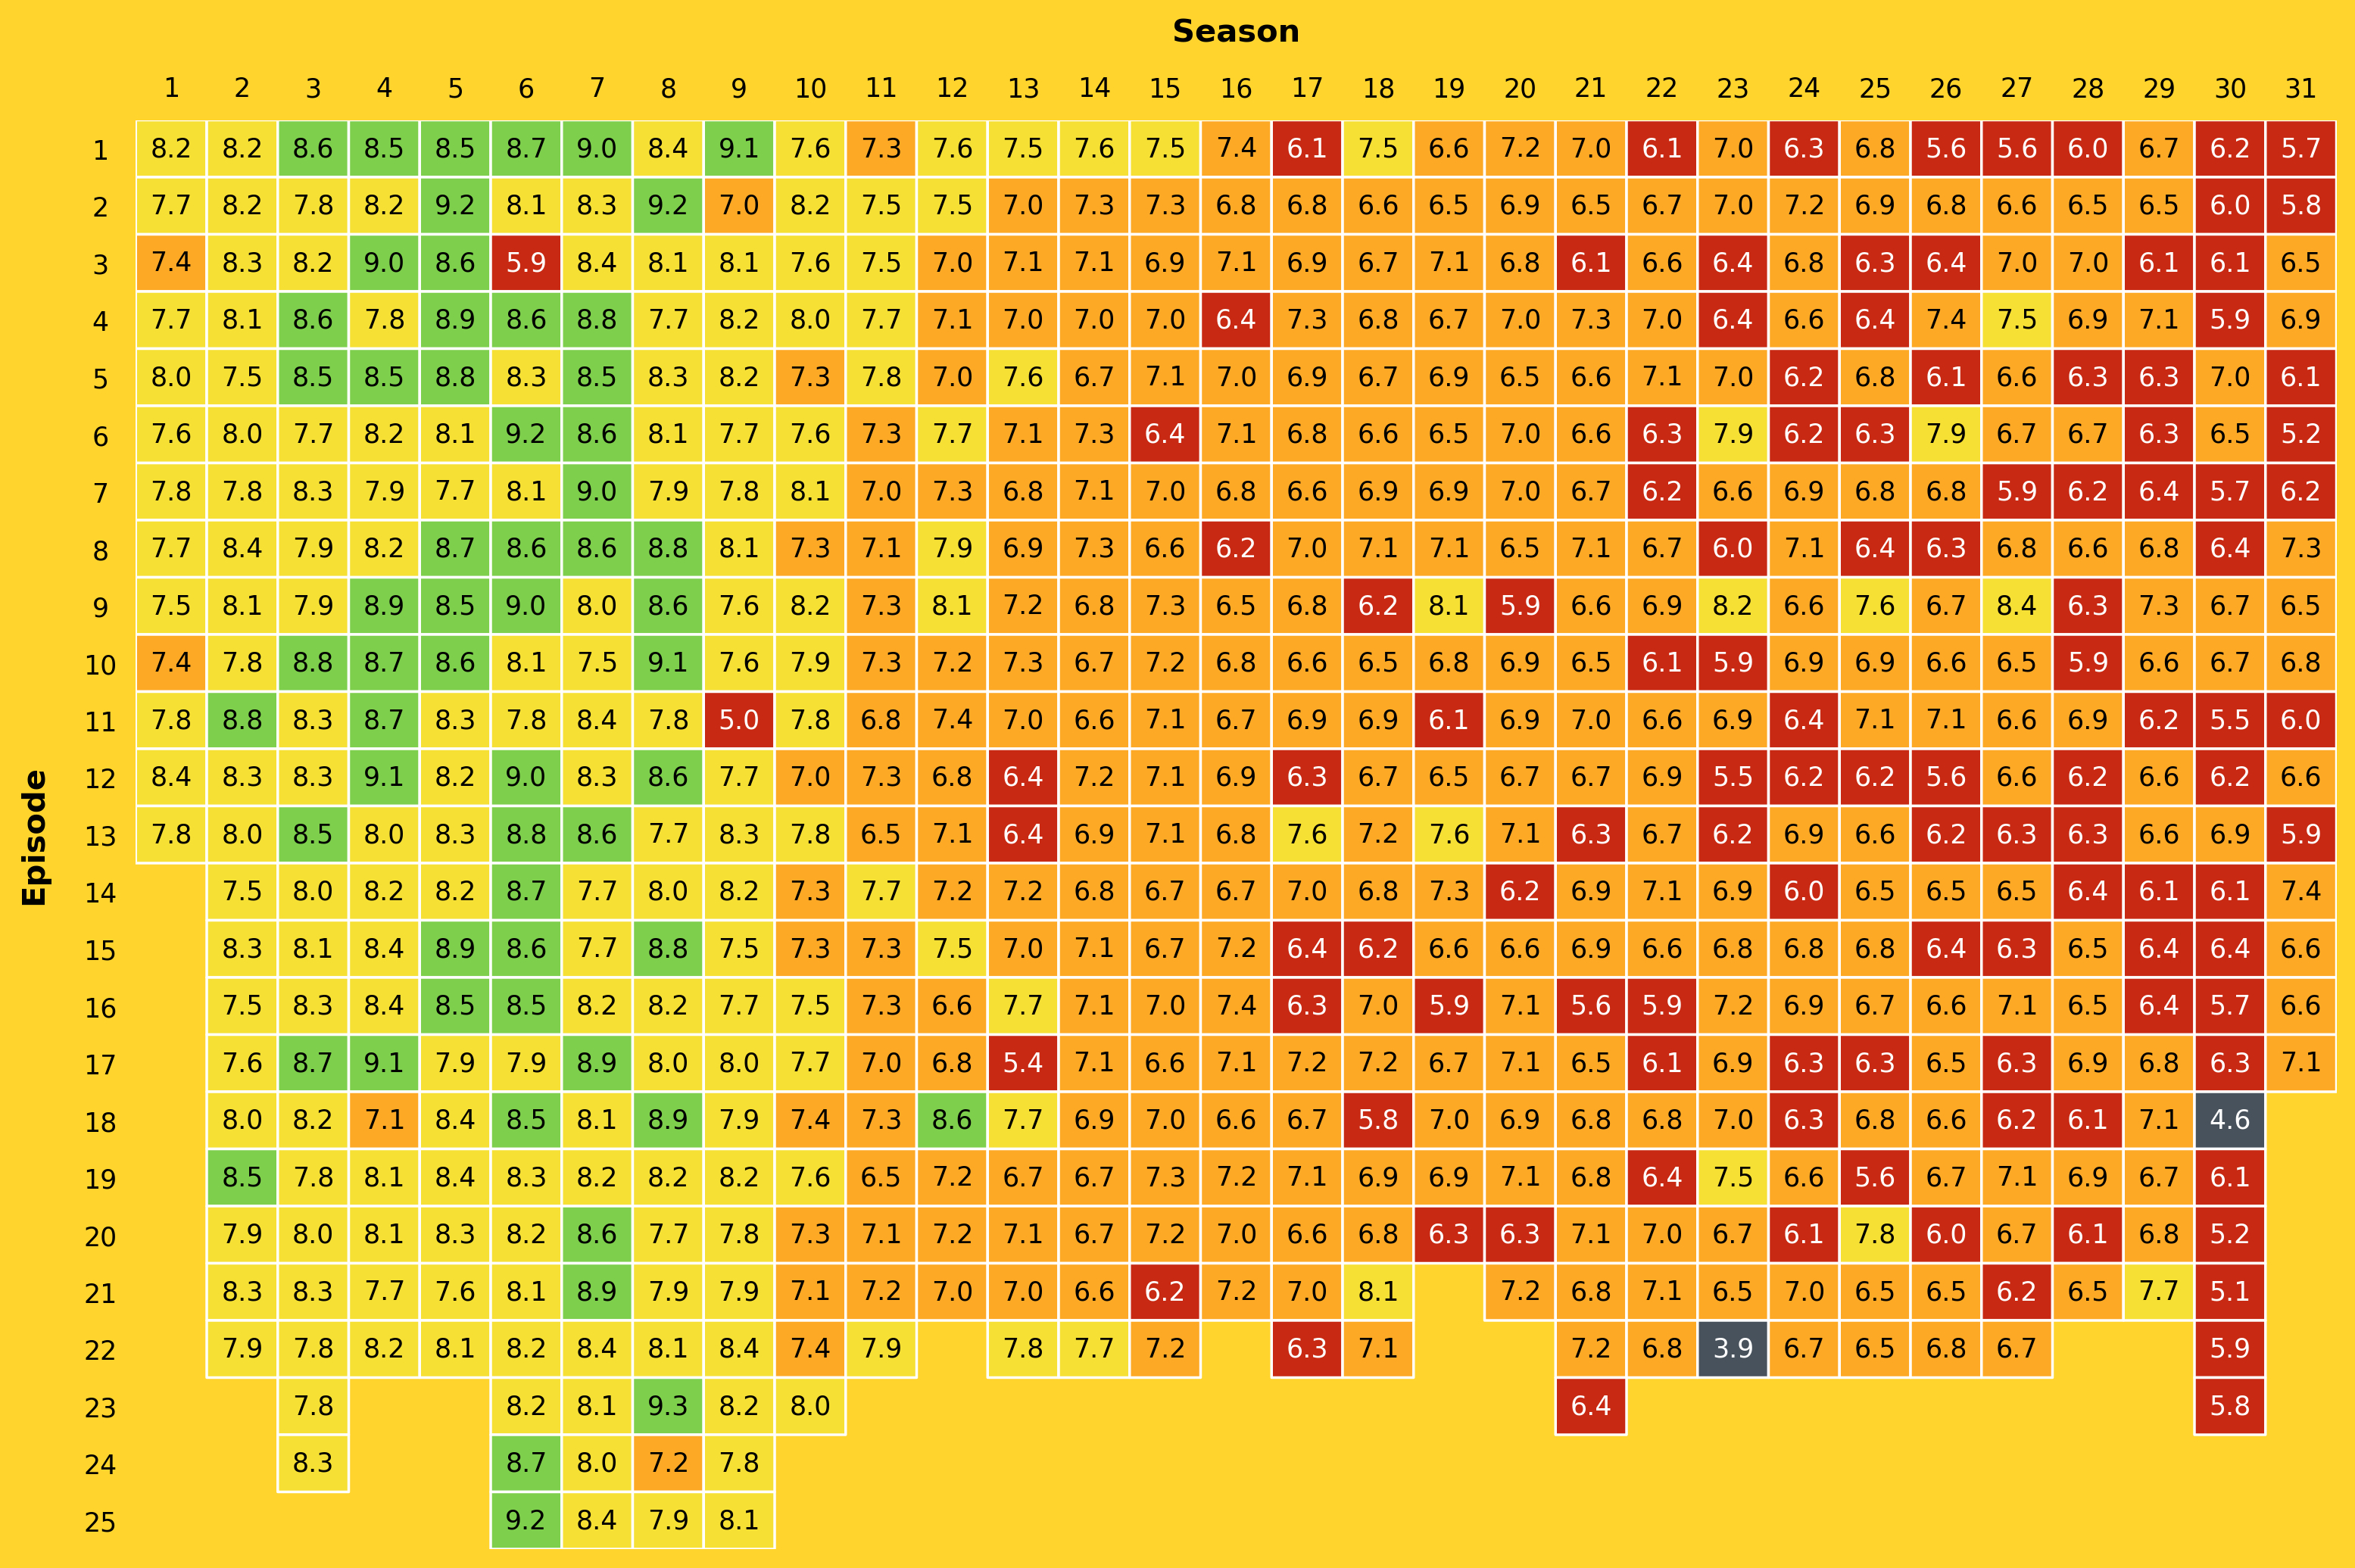

In [11]:
def data_point_2_str(data_point):
    if isinstance(data_point, np.ma.core.MaskedConstant):
        s = ''
    else:
        s = str(data_point)
        
    return s

def data_point_2_font_dict(data_point, fontsize=8, white_threshold=6.5):
    if data_point < white_threshold:
        font_dict = {'color':'white', 
                     'size' : fontsize,
                    }
    else:        
        font_dict = {'color':'black',
                     'size' : fontsize,
                    }
        
    return font_dict
 
def plot_ratings_ax(ax, df_ratings, cm, background, grid_color='white', text_fontsize=10, label_fontsize=12):
    data = df_ratings.fillna(0).values
    data = np.ma.masked_equal(data, 0)

    ax.set_facecolor(background)

    heatmap = ax.pcolor(data, cmap=cm, edgecolors=grid_color, linewidths=1,
                        antialiased=True, vmin=0, vmax=10)

    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            ax.text(x + 0.5, y + 0.5, data_point_2_str(data[y, x]),
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontdict=data_point_2_font_dict(data[y, x], fontsize=text_fontsize),
                   )

    ## Cleaning axis positions and directions
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    ## Adding axis labels
    label_font = {'weight': 'bold',
                  'size': label_fontsize,
                 }
    ax.set_xlabel('Season', labelpad=13, fontdict=label_font)
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('Episode', labelpad=13, fontdict=label_font)

    ax.set_xticks(np.arange(len(df_ratings.columns)) + 0.5)
    ax.set_xticklabels(df_ratings.columns, ha='center', fontdict={'size':text_fontsize})
    ax.set_yticks(np.arange(len(df_ratings.index)) + 0.5)
    ax.set_yticklabels(df_ratings.index, ha='center', fontdict={'size':text_fontsize})

    ax.tick_params(axis='both', which='major', labelsize=10, left=False, top=False)
    ax.tick_params(axis='y', pad=10)
    hide_spines(ax, positions=['top', 'bottom', 'left', 'right'])
    
background = '#FED42D'

fig, ax = plt.subplots(dpi=250, figsize=(15, 10), facecolor=background)
plot_ratings_ax(ax, df_ratings, simpsons_cm, background)

<br>

Next we can  download images for <a href="https://assets.wallpapersin4k.org/uploads/2017/04/The-Simpsons-Phone-Wallpaper-4.jpg">Homer's face</a> and the <a href="https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/The_Simpsons_Logo.svg/1200px-The_Simpsons_Logo.svg.png">Simpsons' logo</a>, combine them (in this case outside of Python), and then plot them as a background image with the legend overlaid

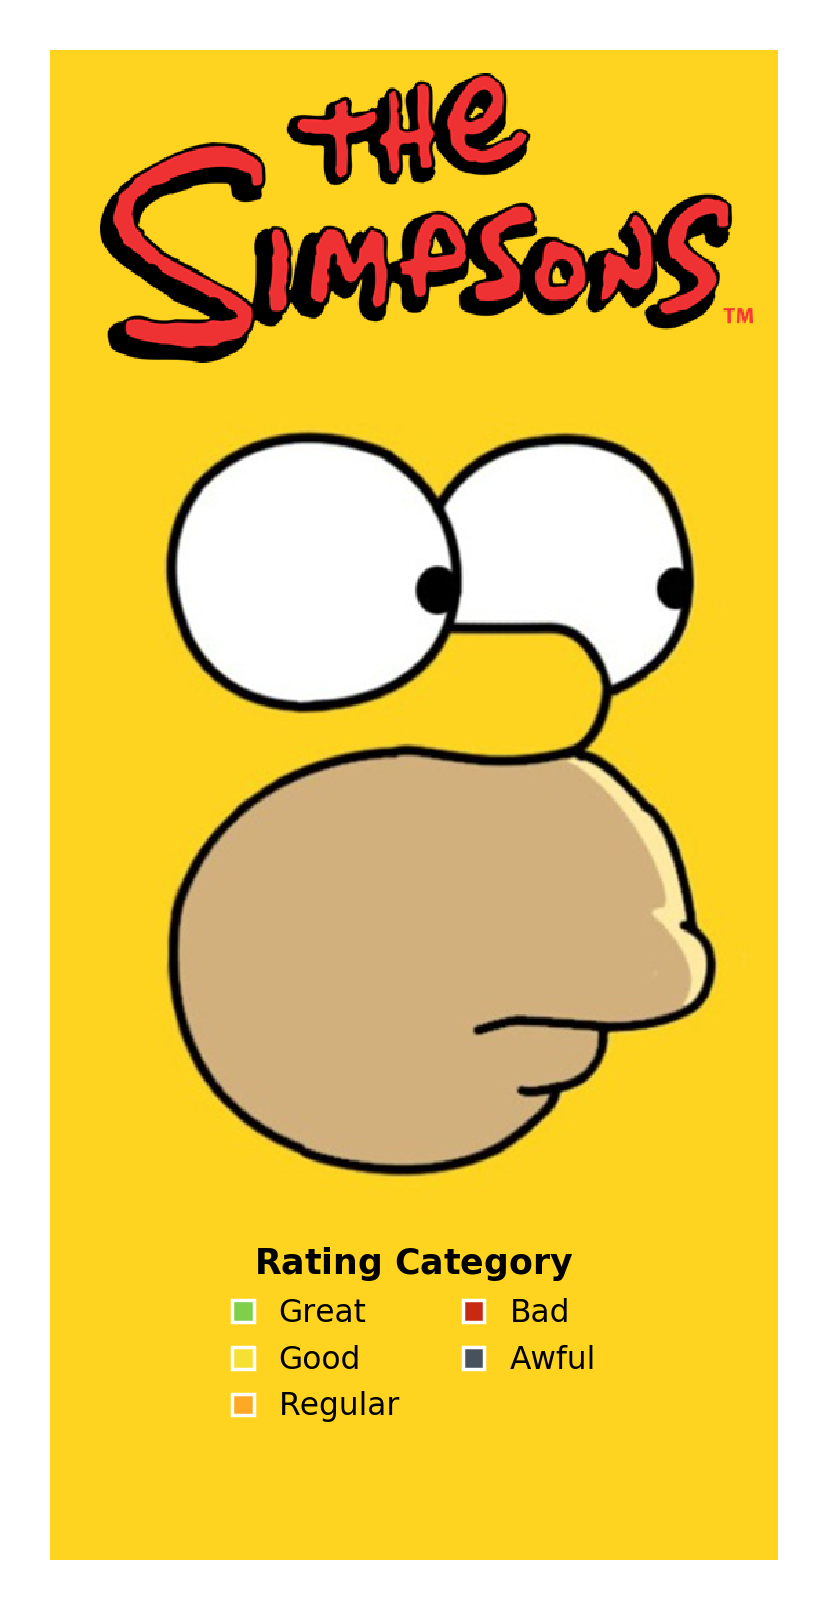

In [14]:
def plot_info_panel(ax, background_img_path, rating_colors, rating_labels, lgnd_edge_color='white', label_fontsize=4.5, title_fontsize=5):
    ## Plotting background image
    img = plt.imread(background_img_path)
    ax.imshow(img)

    ## Creating legend
    patches = [mpatches.Patch(facecolor=color, label=label, edgecolor=lgnd_edge_color, linewidth=0.5) 
               for color, label in zip(rating_colors, rating_labels)]

    leg = ax.legend(handles=patches, ncol=2, frameon=False, handlelength=0.7, bbox_to_anchor=[0.5, 0.15], 
                    loc='center', prop={'size': label_fontsize}, title=r'$\bf{Rating\ Category}$', title_fontsize=title_fontsize)

    ## Cleaning axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    hide_spines(ax, positions=['top', 'bottom', 'left', 'right'])
    
background_img_path = 'img/simpsons/simpsons_background_img.png'
rating_labels = ['Great', 'Good', 'Regular', 'Bad', 'Awful']
rating_colors = colors[::-1]

fig, ax = plt.subplots(dpi=500)
plot_info_panel(ax, background_img_path, rating_colors, rating_labels)

<br>

Finally we can combine these two axes within a single figure

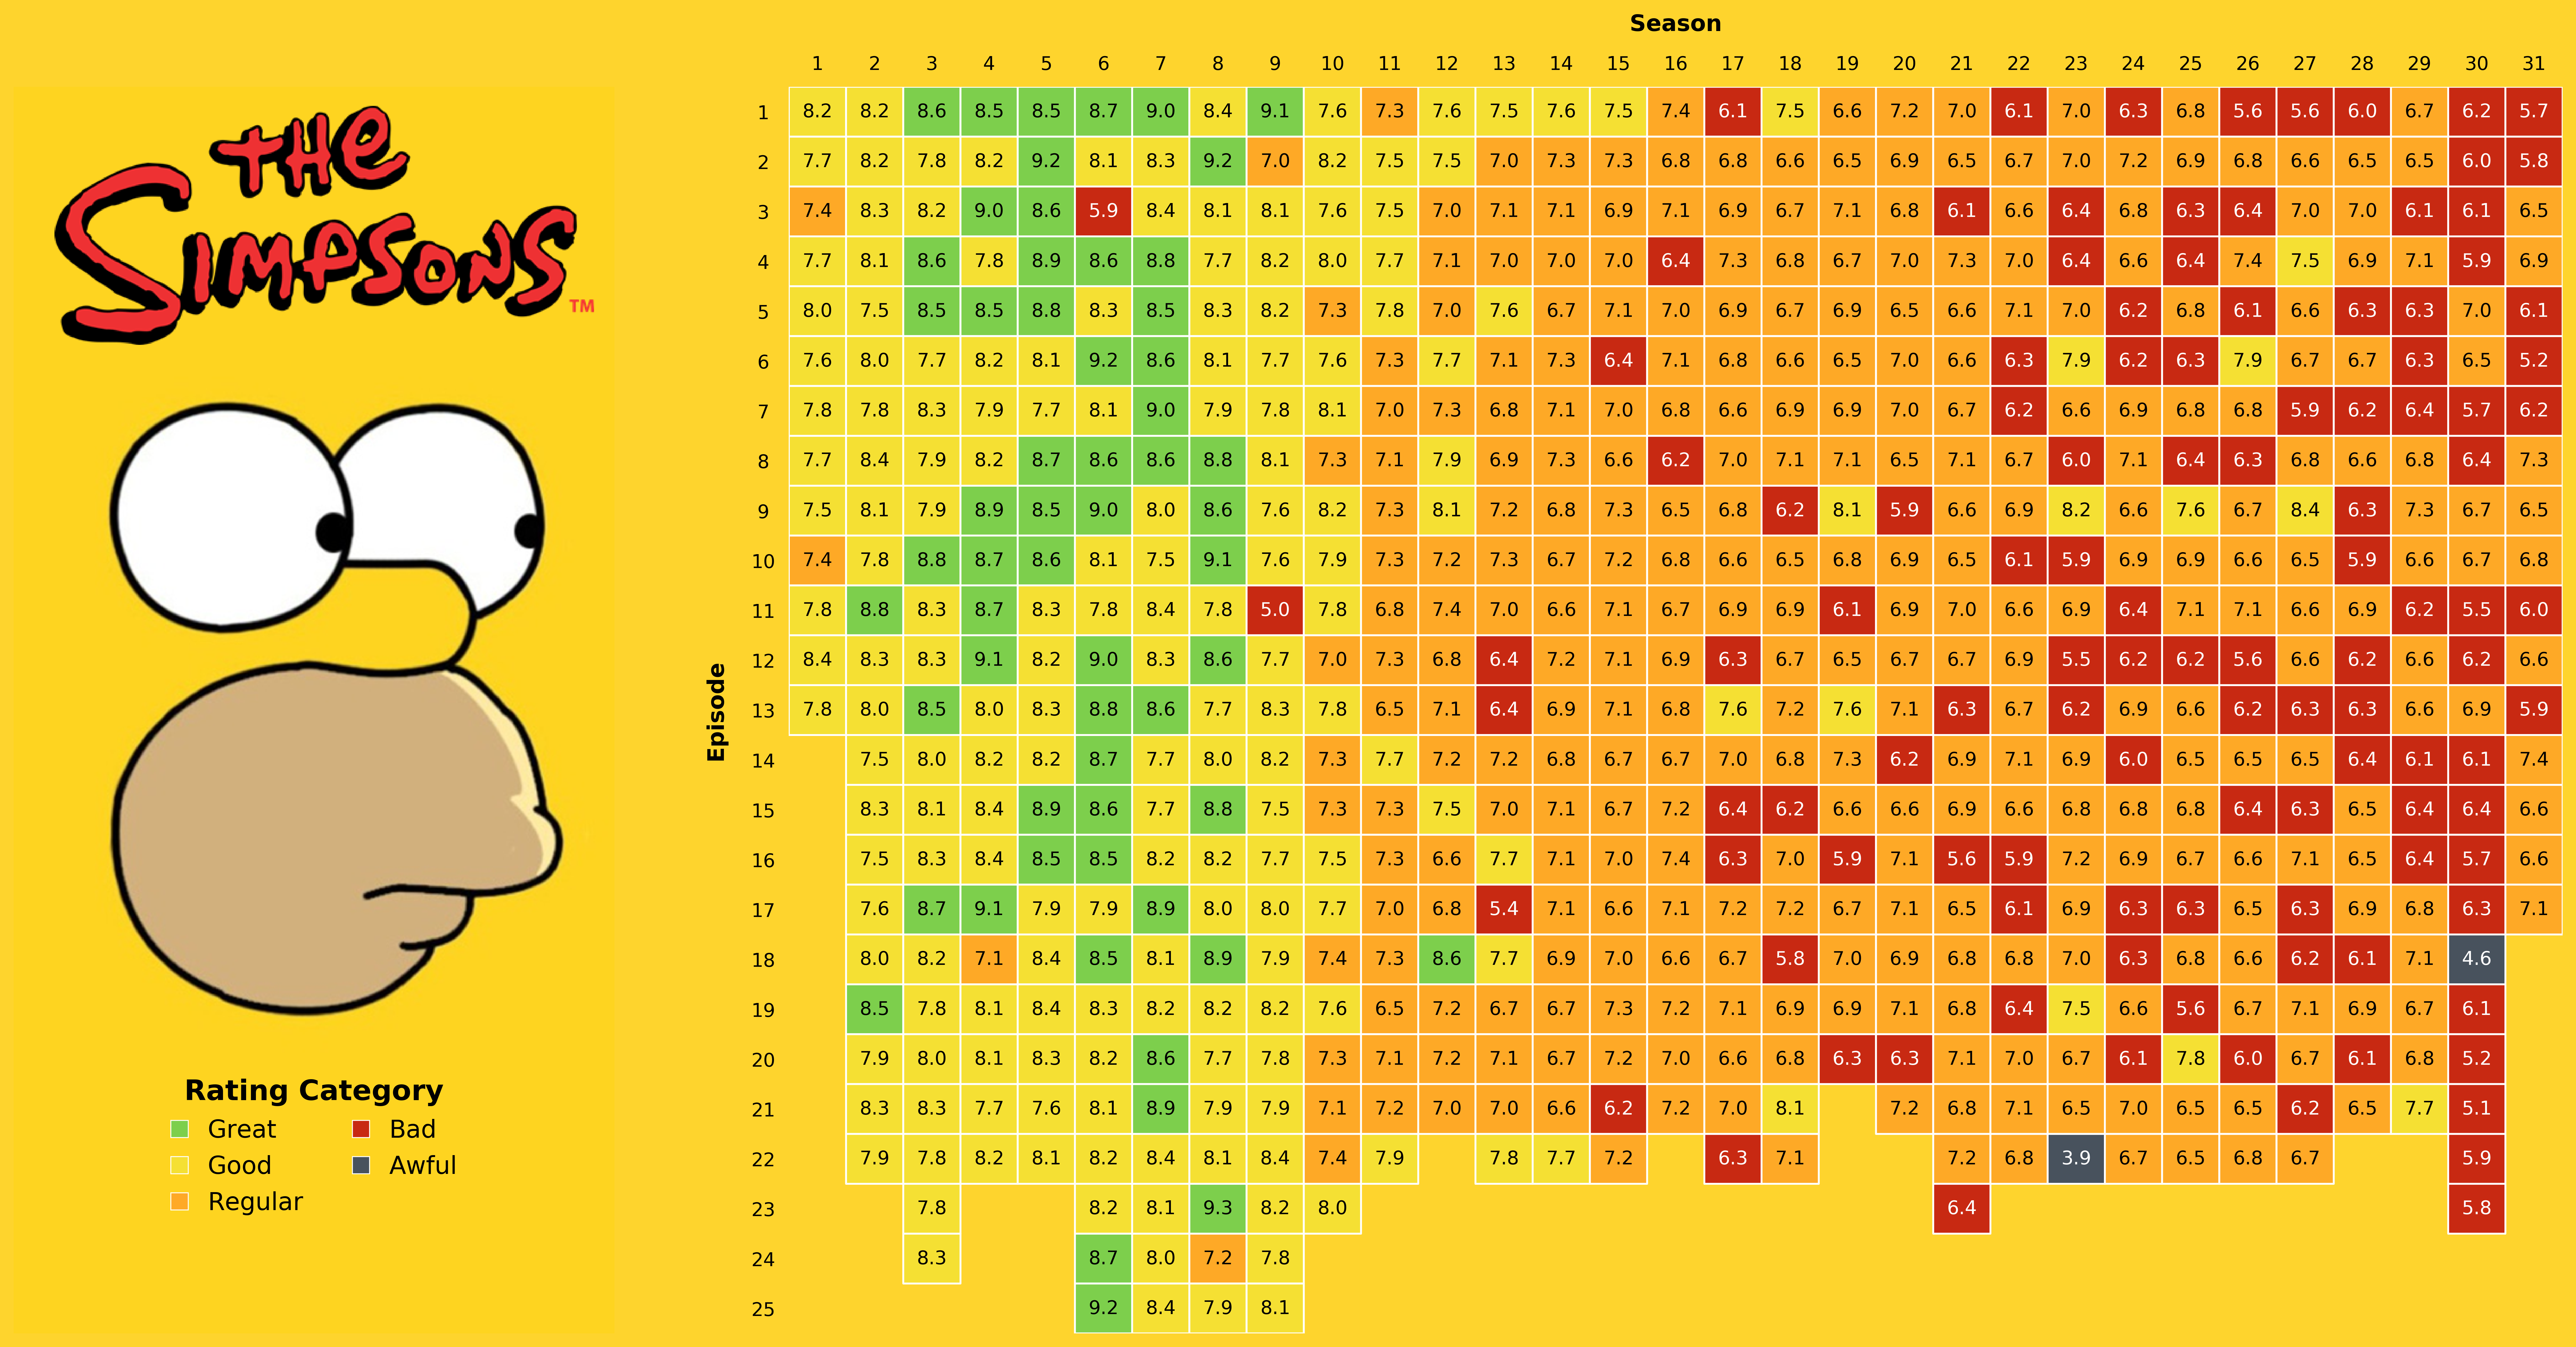

In [18]:
background = '#FED42D'
background_img_path = 'img/simpsons/simpsons_background_img.png'
rating_labels = ['Great', 'Good', 'Regular', 'Bad', 'Awful']
rating_colors = colors[::-1]

fig = plt.figure(dpi=500, figsize=(20, 10), facecolor=background)
gs = fig.add_gridspec(1, 3)

info_ax = fig.add_subplot(gs[0, 0])
ratings_ax = fig.add_subplot(gs[0, 1:])

plot_info_panel(info_ax, background_img_path, rating_colors, rating_labels, 
                label_fontsize=13, title_fontsize=15)
plot_ratings_ax(ratings_ax, df_ratings, simpsons_cm, background)

fig.tight_layout()
fig.savefig('img/simpsons/finished_graphic.png', facecolor=background)